### [Ignorar] **Librerías para Colab**

In [ ]:
%pip install --upgrade "transformers>=4.45.1" --quiet # Es necesario esta version para entorno cuda con cuantizacion (en colab)
%pip install intel_extension_for_pytorch --quiet
%pip install -U bitsandbytes --quiet
%pip uninstall -y torch torchvision torchaudio numpy --quiet
%pip install torch torchvision torchaudio numpy==1.26.4 --quiet # Evitar conflictos con NumPy 2.2.3
%pip install --upgrade accelerate --quiet #deepspeed
%pip install unsloth --quiet

In [ ]:
import torch
print(torch.cuda.is_available())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 
---

# 1. **IR1 - Default Semantic Similarity Retrieval (L2 distance) with FAISS**
---
Se usa inicialmente FAISS. Enlace: `https://github.com/facebookresearch/faiss/wiki`

Faiss es una biblioteca desarrollada por Meta AI Research para realizar búsquedas de similitud y agrupamiento (clustering) eficiente sobre vectores densos. Está escrita en C++ y tiene wrappers completos en Python. Algunos algoritmos están optimizados para GPU y puede trabajar con conjuntos de vectores que no caben en memoria RAM.

¿Qué es una búsqueda de similitud?
Dado un conjunto de vectores {x₁, ..., xₙ} en un espacio de dimensión d, Faiss construye una estructura de datos (índice) en RAM que permite encontrar de forma eficiente el vector más cercano a otro vector x, normalmente usando la distancia Euclidiana (‖x − xᵢ‖) o el producto escalar máximo (⟨x, xᵢ⟩).

Características principales de Faiss:

- Búsqueda del vecino más cercano (k-NN), no solo del primero sino de los k más próximos.
- Procesamiento por lotes: permite buscar varios vectores al mismo tiempo.
- Admite diferentes métricas (L2, L1, Linf...).
- Puede almacenar el índice en disco en lugar de RAM.



> **Nota:** La generación de embeddings a partir de los documentos de Wikipedia del dataset **FEVER**, usando un modelo **BGE**, puede integrarse en un único pipeline con **LangChain**:
>
> `DOCUMENTS → ENCODING → INDEXING → RETRIEVAL`
>
> **LangChain** es una librería de Python diseñada para construir aplicaciones complejas con modelos de lenguaje (LLMs). Permite conectar componentes como:
>
> - Modelos de lenguaje (OpenAI, Hugging Face, LLaMA, etc.)
> - Fuentes de conocimiento (PDFs, web, bases de datos, etc.)
> - Motores vectoriales (FAISS, Chroma, etc.)
> - Lógica, memoria y flujos conversacionales

## Imports

In [ ]:
# Setting up the device for GPU usage
import torch
from torch import cuda
import json
import time
from huggingface_hub import list_datasets
from datasets import load_dataset
from datasets import Dataset, DownloadConfig
from torch.utils.data import Dataset, DataLoader
import sys
import pandas as pd

In [16]:
%pip install unsloth --quiet

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import gc

gc.collect()

6

In [ ]:
torch.cuda.empty_cache()

In [1]:
!nvidia-smi

Sat Jun 21 17:04:21 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     Off | 00000000:15:00.0 Off |                    0 |
|  0%   33C    P8              22W / 300W |      3MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [40]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

Number of GPUs available: 1
GPU 0: NVIDIA A40


In [5]:
device = torch.device(f'cuda:0')

In [6]:
torch.cuda.get_device_name(device)

'NVIDIA A40'

In [17]:
%pip install datasets --quiet

Note: you may need to restart the kernel to use updated packages.


## **Carga de wiki-pages**
---

In [21]:
from huggingface_hub import hf_hub_download
import os
import shutil

output_dir = "wiki-embeds"
os.makedirs(output_dir, exist_ok=True)

repo_id = "JORGEDC01/Demo1"

remote_dir = "wiki-pages/Embeddings_WikiPages/bge_small_en_v1.5/jsonl"

for i in range(1, 101):
    filename = f"wiki-{str(i).zfill(3)}.jsonl"
    print(f"Descargando: {filename}")
    
    downloaded_path = hf_hub_download(
        repo_id=repo_id,
        filename=os.path.join(remote_dir, filename),
        repo_type="dataset",
        cache_dir=".hf_cache" 
    )
    
    shutil.copy(downloaded_path, os.path.join(output_dir, filename))


Descargando: wiki-001.jsonl


wiki-001.jsonl:   0%|          | 0.00/280M [00:00<?, ?B/s]

Descargando: wiki-002.jsonl


wiki-002.jsonl:   0%|          | 0.00/280M [00:00<?, ?B/s]

Descargando: wiki-003.jsonl


wiki-003.jsonl:   0%|          | 0.00/283M [00:00<?, ?B/s]

Descargando: wiki-004.jsonl


wiki-004.jsonl:   0%|          | 0.00/283M [00:00<?, ?B/s]

Descargando: wiki-005.jsonl


wiki-005.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Descargando: wiki-006.jsonl


wiki-006.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Descargando: wiki-007.jsonl


wiki-007.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-008.jsonl


wiki-008.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-009.jsonl


wiki-009.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-010.jsonl


wiki-010.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-011.jsonl


wiki-011.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-012.jsonl


wiki-012.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-013.jsonl


wiki-013.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-014.jsonl


wiki-014.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-015.jsonl


wiki-015.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-016.jsonl


wiki-016.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-017.jsonl


wiki-017.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-018.jsonl


wiki-018.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-019.jsonl


wiki-019.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Descargando: wiki-020.jsonl


wiki-020.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-021.jsonl


wiki-021.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-022.jsonl


wiki-022.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-023.jsonl


wiki-023.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-024.jsonl


wiki-024.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-025.jsonl


wiki-025.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-026.jsonl


wiki-026.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-027.jsonl


wiki-027.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-028.jsonl


wiki-028.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-029.jsonl


wiki-029.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-030.jsonl


wiki-030.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-031.jsonl


wiki-031.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-032.jsonl


wiki-032.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-033.jsonl


wiki-033.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-034.jsonl


wiki-034.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-035.jsonl


wiki-035.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-036.jsonl


wiki-036.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-037.jsonl


wiki-037.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-038.jsonl


wiki-038.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-039.jsonl


wiki-039.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-040.jsonl


wiki-040.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-041.jsonl


wiki-041.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-042.jsonl


wiki-042.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-043.jsonl


wiki-043.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-044.jsonl


wiki-044.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-045.jsonl


wiki-045.jsonl:   0%|          | 0.00/289M [00:00<?, ?B/s]

Descargando: wiki-046.jsonl


wiki-046.jsonl:   0%|          | 0.00/289M [00:00<?, ?B/s]

Descargando: wiki-047.jsonl


wiki-047.jsonl:   0%|          | 0.00/290M [00:00<?, ?B/s]

Descargando: wiki-048.jsonl


wiki-048.jsonl:   0%|          | 0.00/289M [00:00<?, ?B/s]

Descargando: wiki-049.jsonl


wiki-049.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-050.jsonl


wiki-050.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-051.jsonl


wiki-051.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-052.jsonl


wiki-052.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-053.jsonl


wiki-053.jsonl:   0%|          | 0.00/284M [00:00<?, ?B/s]

Descargando: wiki-054.jsonl


wiki-054.jsonl:   0%|          | 0.00/284M [00:00<?, ?B/s]

Descargando: wiki-055.jsonl


wiki-055.jsonl:   0%|          | 0.00/284M [00:00<?, ?B/s]

Descargando: wiki-056.jsonl


wiki-056.jsonl:   0%|          | 0.00/284M [00:00<?, ?B/s]

Descargando: wiki-057.jsonl


wiki-057.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-058.jsonl


wiki-058.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-059.jsonl


wiki-059.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-060.jsonl


wiki-060.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-061.jsonl


wiki-061.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-062.jsonl


wiki-062.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Descargando: wiki-063.jsonl


wiki-063.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-064.jsonl


wiki-064.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-065.jsonl


wiki-065.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-066.jsonl


wiki-066.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-067.jsonl


wiki-067.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-068.jsonl


wiki-068.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-069.jsonl


wiki-069.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-070.jsonl


wiki-070.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-071.jsonl


wiki-071.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-072.jsonl


wiki-072.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-073.jsonl


wiki-073.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-074.jsonl


wiki-074.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-075.jsonl


wiki-075.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-076.jsonl


wiki-076.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-077.jsonl


wiki-077.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-078.jsonl


wiki-078.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-079.jsonl


wiki-079.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-080.jsonl


wiki-080.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-081.jsonl


wiki-081.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-082.jsonl


wiki-082.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-083.jsonl


wiki-083.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-084.jsonl


wiki-084.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-085.jsonl


wiki-085.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-086.jsonl


wiki-086.jsonl:   0%|          | 0.00/284M [00:00<?, ?B/s]

Descargando: wiki-087.jsonl


wiki-087.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Descargando: wiki-088.jsonl


wiki-088.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-089.jsonl


wiki-089.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-090.jsonl


wiki-090.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-091.jsonl


wiki-091.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-092.jsonl


wiki-092.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-093.jsonl


wiki-093.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-094.jsonl


wiki-094.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-095.jsonl


wiki-095.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Descargando: wiki-096.jsonl


wiki-096.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Descargando: wiki-097.jsonl


wiki-097.jsonl:   0%|          | 0.00/289M [00:00<?, ?B/s]

Descargando: wiki-098.jsonl


wiki-098.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-099.jsonl


wiki-099.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Descargando: wiki-100.jsonl


wiki-100.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Cuando se usa FAISS para construir un índice con `IndexFlatIP`, se utiliza el **producto punto (dot product)** como métrica de similitud. Pero en muchos casos, se desea recuperar vectores basándonos en la **similitud coseno**.

- **Producto punto**: favorece vectores que tengan **mayor magnitud** (más "largos"), no necesariamente los más parecidos en dirección.
- **Similitud coseno**: mide el **ángulo** entre los vectores, independientemente de su magnitud. Es más útil cuando trabajamos con embeddings de lenguaje, ya que compara la **dirección** del significado.

Al normalizar todos los embeddings con `faiss.normalize_L2(...)`, se convierte cada vector en un **vector unitario**, es decir, con norma L2 = 1. La similitud por coseno trabaja con vectores que toman valores entre 0 y 1.

> Normalizar embeddings con `faiss.normalize_L2(...)` es **imprescindible** si queremos que `IndexFlatIP` se comporte como un índice por **similitud coseno**.

Esto asegura resultados más relevantes en tareas de recuperación basada en embeddings.

## **Creación del índice FAISS**
---

In [7]:
import os
import numpy as np
import faiss
import json
import time
from datasets import load_dataset

data_dir = "wiki-embeds"
output_dir = "faiss_index_output"
os.makedirs(output_dir, exist_ok=True)

print("Inicializando índice FAISS (IndexFlatIP)")
dim = 384  
index = faiss.IndexFlatIP(dim)

metadata_file = os.path.join(output_dir, "wiki_metadata.jsonl")

start_global = time.time() 
start_block = time.time()  

with open(metadata_file, "w") as metafile:
    for i in range(1, 101):
        file = f"{data_dir}/wiki-{str(i).zfill(3)}.jsonl"
        print(f"Procesando archivo {i}/100: {file}")
        
        ds = load_dataset("json", data_files=file, split="train")

        embeddings = np.vstack(ds['text_embedding']).astype('float32')
        faiss.normalize_L2(embeddings)
        index.add(embeddings)

        for record in ds:
            metafile.write(json.dumps({
                "id": record["id"],
                "embedding": record["text_embedding"]
            }) + "\n")

        if i % 10 == 0:
            elapsed_block = time.time() - start_block
            elapsed_total = time.time() - start_global
            print(f"--> Tiempo para archivos {i-9}-{i}: {elapsed_block:.2f}s | Tiempo total: {elapsed_total:.2f}s")
            start_block = time.time()

faiss.write_index(index, os.path.join(output_dir, "wiki_faiss.index"))
print(f"Proceso completado en {time.time() - start_global:.2f} segundos.")

Inicializando índice FAISS (IndexFlatIP)
Procesando archivo 1/100: wiki-embeds/wiki-001.jsonl
Procesando archivo 2/100: wiki-embeds/wiki-002.jsonl
Procesando archivo 3/100: wiki-embeds/wiki-003.jsonl
Procesando archivo 4/100: wiki-embeds/wiki-004.jsonl
Procesando archivo 5/100: wiki-embeds/wiki-005.jsonl
Procesando archivo 6/100: wiki-embeds/wiki-006.jsonl
Procesando archivo 7/100: wiki-embeds/wiki-007.jsonl
Procesando archivo 8/100: wiki-embeds/wiki-008.jsonl
Procesando archivo 9/100: wiki-embeds/wiki-009.jsonl
Procesando archivo 10/100: wiki-embeds/wiki-010.jsonl
--> Tiempo para archivos 1-10: 399.96s | Tiempo total: 399.96s
Procesando archivo 11/100: wiki-embeds/wiki-011.jsonl
Procesando archivo 12/100: wiki-embeds/wiki-012.jsonl
Procesando archivo 13/100: wiki-embeds/wiki-013.jsonl
Procesando archivo 14/100: wiki-embeds/wiki-014.jsonl
Procesando archivo 15/100: wiki-embeds/wiki-015.jsonl
Procesando archivo 16/100: wiki-embeds/wiki-016.jsonl
Procesando archivo 17/100: wiki-embeds/wi

No solo se desea evaluar cómo afecta el módulo de information retrieval al rendimiento del modelo, sino también la tasa de acierto de los embeddings recuperados con respecto las evidencias definidas del dataset de FEVER. Los pasos son los siguientes:

1. Crear el Test set [1] con las evidencias, label, claim y distractores
2. A partir de [1], se crea un segundo Test set que contenga: [claim_emb, label, distractores, evidencias_recuperadas_IR]
3. Evaluación del módulo IR: [elegir métrica para evaluar el grado de acierto]

`Comparativa:
    Baseline: recuperación simple con FAISS sobre BGE
    Variantes: + reranking, + query enrichment, + hybrid dense/sparse`

## **Recuperación de evidencias por distancia coseno**
---

In [13]:
df_test_OR = pd.read_json("../data/e_test_distractors_LoRA_split.jsonl", lines=True)

In [12]:
df_test_OR.head(5)

,verifiable,label,claim,claim_embedding,evidence,distractors
0,VERIFIABLE,SUPPORTS,Ukrainian Soviet Socialist Republic was a foun...,"[-0.0591153502, -0.0126818949, 0.0383902341000...",[],"[[0.0532539971, 0.0260050241, 0.013253429, -0...."
1,VERIFIABLE,SUPPORTS,2 Hearts is a musical composition by Minogue.,"[0.0180077925, -0.026540124800000002, -0.00647...","[[0.0320139751, -0.0227532443, -0.0038726702, ...","[[-0.005198182500000001, 0.0173794962, -0.0174..."
2,VERIFIABLE,REFUTES,The New Jersey Turnpike has zero shoulders.,"[0.0251651835, 0.0128200827, -0.0223469585, -0...","[[-0.0065970495, -0.0365960449, -0.0052183238,...","[[-0.0294236168, 0.0439332686, -0.0221149325, ..."
3,NOT VERIFIABLE,NOT ENOUGH INFO,Legendary Entertainment is the owner of Wanda ...,"[0.0150281349, -0.0019458425, 0.02721324380000...",[],"[[-0.0443192981, 0.0111048901, 0.045511771, -0..."
4,VERIFIABLE,REFUTES,Aruba is the only ABC Island.,"[0.0502280593, 0.0248907488, -0.0449585803, -0...","[[0.0288720019, -0.000586619, -0.0141577022, 0...","[[-0.0247019697, 0.0798536614, 0.0267286226, -..."


In [16]:
import numpy as np
import faiss
import json
import pandas as pd
from tqdm import tqdm

index = faiss.read_index("faiss_index_output/wiki_faiss.index")

# EMBEDDINGS ORIGINALES
original_embeddings = []
with open("faiss_index_output/wiki_metadata.jsonl", "r") as f:
    for line in f:
        obj = json.loads(line)
        original_embeddings.append(obj["embedding"])
original_embeddings = np.array(original_embeddings, dtype='float32')

# CARGA POR BATCHES
batch_size = 1000
df_test_IR = df_test_OR.copy()
all_evidencias = []

print("### Procesando claims por lotes")
for start in tqdm(range(0, len(df_test_OR), batch_size), desc="Procesando claims"):
    end = min(start + batch_size, len(df_test_OR))
    batch_embeddings = np.vstack(df_test_OR.iloc[start:end]['claim_embedding'].values).astype('float32')
    
    normalized_batch = batch_embeddings.copy()
    faiss.normalize_L2(normalized_batch)

    k = 2
    distances, indices = index.search(normalized_batch, k)

    batch_evidencias = [
        [original_embeddings[i].tolist() for i in idx_list]
        for idx_list in indices
    ]
    
    all_evidencias.extend(batch_evidencias)

df_test_IR["evidence"] = all_evidencias

df_test_IR.to_json("testSet_default_faiss.jsonl", orient="records", lines=True)

### Procesando claims por lotes


Procesando claims: 100%|██████████| 10/10 [49:51<00:00, 299.17s/it]


In [14]:
import numpy as np
import faiss
import json
import pandas as pd
from tqdm import tqdm

# === Cargar índice FAISS ===
index = faiss.read_index("faiss_index_output/wiki_faiss.index")

# === Cargar embeddings originales ===
original_embeddings = []
with open("faiss_index_output/wiki_metadata.jsonl", "r") as f:
    for line in f:
        obj = json.loads(line)
        original_embeddings.append(obj["embedding"])
original_embeddings = np.array(original_embeddings, dtype='float32')

# === Paso 1: Separar NEIs ===
neis = df_test_OR[df_test_OR["label"] == "NOT ENOUGH INFO"].copy()
df_verifiable = df_test_OR[df_test_OR["label"] != "NOT ENOUGH INFO"].copy()

# === Paso 2: Recuperar evidencias solo para verifiable ===
batch_size = 1000
all_evidencias = []

print("### Procesando claims por lotes (sin NEIs)")
for start in tqdm(range(0, len(df_verifiable), batch_size), desc="Procesando claims"):
    end = min(start + batch_size, len(df_verifiable))
    
    batch_embeddings = np.vstack(df_verifiable.iloc[start:end]['claim_embedding'].values).astype('float32')
    faiss.normalize_L2(batch_embeddings)
    
    k = 2
    distances, indices = index.search(batch_embeddings, k)
    
    batch_evidencias = [
        [original_embeddings[i].tolist() for i in idx_list]
        for idx_list in indices
    ]
    all_evidencias.extend(batch_evidencias)

# Asignar evidencias recuperadas
df_verifiable["evidence"] = all_evidencias

# === Paso 3: Unir NEIs de vuelta ===
# Asegurate que NEIs tengan evidencia vacía
neis["evidence"] = [[] for _ in range(len(neis))]

# Unir todo
df_final = pd.concat([df_verifiable, neis], ignore_index=True)

# === Guardar resultado ===
df_final.to_json("testSet_default_faiss.jsonl", orient="records", lines=True)
print("✅ Archivo guardado con evidencias solo para verifiable.")


### Procesando claims por lotes (sin NEIs)


Procesando claims: 100%|██████████| 7/7 [33:00<00:00, 282.98s/it]


✅ Archivo guardado con evidencias solo para verifiable.


In [15]:
print(df_final['label'].value_counts())


label
SUPPORTS           3333
REFUTES            3333
NOT ENOUGH INFO    3332
Name: count, dtype: int64


## **Evaluación del módulo IR Desacoplado**
---

> Lectura del nuevo test set recuperado...

In [10]:
df_test_IR = pd.read_json("testSet_default_faiss.jsonl", lines=True)

In [11]:
df_test_IR.head(5)

,label,claim_embedding,distractors,evidences
0,SUPPORTS,"[-0.0591153502, -0.0126818949, 0.0383902341000...","[[0.0532539971, 0.0260050241, 0.013253429, -0....","[[-0.0212658644, -0.0053822184, 0.049857523300..."
1,SUPPORTS,"[0.0180077925, -0.026540124800000002, -0.00647...","[[-0.005198182500000001, 0.0173794962, -0.0174...","[[0.0320139751, -0.0227532443, -0.0038726702, ..."
2,REFUTES,"[0.0251651835, 0.0128200827, -0.0223469585, -0...","[[-0.0294236168, 0.0439332686, -0.0221149325, ...","[[-0.0065970495, -0.0365960449, -0.0052183238,..."
3,NOT ENOUGH INFO,"[0.0150281349, -0.0019458425, 0.02721324380000...","[[-0.0443192981, 0.0111048901, 0.045511771, -0...","[[0.0053903144, 0.0107809063, 0.0558740608, -0..."
4,REFUTES,"[0.0502280593, 0.0248907488, -0.0449585803, -0...","[[-0.0247019697, 0.0798536614, 0.0267286226, -...","[[0.0217998195, -0.0067899507, -0.0060096984, ..."


> Lectura del test set original...

In [14]:
df_test_OR = pd.read_json("../data/e_test_distractors_LoRA_split.jsonl", lines=True)

In [15]:
df_test_OR.head(5)

,verifiable,label,claim,claim_embedding,evidence,distractors
0,VERIFIABLE,SUPPORTS,Ukrainian Soviet Socialist Republic was a foun...,"[-0.0591153502, -0.0126818949, 0.0383902341000...",[],"[[0.0532539971, 0.0260050241, 0.013253429, -0...."
1,VERIFIABLE,SUPPORTS,2 Hearts is a musical composition by Minogue.,"[0.0180077925, -0.026540124800000002, -0.00647...","[[0.0320139751, -0.0227532443, -0.0038726702, ...","[[-0.005198182500000001, 0.0173794962, -0.0174..."
2,VERIFIABLE,REFUTES,The New Jersey Turnpike has zero shoulders.,"[0.0251651835, 0.0128200827, -0.0223469585, -0...","[[-0.0065970495, -0.0365960449, -0.0052183238,...","[[-0.0294236168, 0.0439332686, -0.0221149325, ..."
3,NOT VERIFIABLE,NOT ENOUGH INFO,Legendary Entertainment is the owner of Wanda ...,"[0.0150281349, -0.0019458425, 0.02721324380000...",[],"[[-0.0443192981, 0.0111048901, 0.045511771, -0..."
4,VERIFIABLE,REFUTES,Aruba is the only ABC Island.,"[0.0502280593, 0.0248907488, -0.0449585803, -0...","[[0.0288720019, -0.000586619, -0.0141577022, 0...","[[-0.0247019697, 0.0798536614, 0.0267286226, -..."


In [23]:
num_filas_sin_evidencia = df_test_OR[df_test_OR['evidence'].apply(lambda x: x == [])].shape[0]

print(f"Número de filas con evidencia vacía ([]): {num_filas_sin_evidencia}")

Número de filas con evidencia vacía ([]): 3828


In [31]:
def limpiar_evidencias(lista_embs): # elimina listas vacias en evidences que tienen varias evidencias, para solucionar el problema de vstack.
    if isinstance(lista_embs, list):
        lista_filtrada = [e for e in lista_embs if isinstance(e, list) and len(e) > 0]
        return lista_filtrada
    return lista_embs

df_test_OR['evidence'] = df_test_OR['evidence'].apply(limpiar_evidencias)

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def embedding_recall_at_k(row_ir, row_or, k=2, sim_threshold=0.9):
    retrieved_embs = row_ir['evidences'][:k]  
    gold_embs = row_or['evidence']           

    try:
        retrieved_embs = np.vstack(retrieved_embs).astype(np.float32)
        gold_embs = np.vstack(gold_embs).astype(np.float32)
    except Exception as e:
        return None

    if gold_embs.size == 0 or len(gold_embs) == 0:
        return None 

    sims = cosine_similarity(retrieved_embs, gold_embs)  # shape (k, n_gold)
    max_sim = np.max(sims)

    return int(max_sim >= sim_threshold)


total_filas = len(df_test_IR)

# Evidences no vacias
indices_validos = df_test_OR['evidence'].apply(lambda x: len(x) > 0) # se eliminan las muestras NEIs
df_test_IR_valid = df_test_IR[indices_validos].reset_index(drop=True)
df_test_OR_valid = df_test_OR[indices_validos].reset_index(drop=True)
filas_con_evidencia = len(df_test_IR_valid)

recalls = []
for i in range(filas_con_evidencia):
    row_ir = df_test_IR_valid.iloc[i]
    row_or = df_test_OR_valid.iloc[i]
    score = embedding_recall_at_k(row_ir, row_or, k=2, sim_threshold=0.9)
    if score is not None:
        recalls.append(score)

filas_usadas = len(recalls)
recall_embedding = sum(recalls) / filas_usadas if filas_usadas > 0 else 0

print(f"Total filas: {total_filas}")
print(f"Filas con evidencia (válidas para recall): {filas_con_evidencia}")
print(f"Filas usadas para cálculo de recall (score != None): {filas_usadas}")
print(f"Recall@2 (embedding, threshold 0.9) sobre filas con evidencia: {recall_embedding:.4f}")

Total filas: 9998
Filas con evidencia (válidas para recall): 6170
Filas usadas para cálculo de recall (score != None): 6170
Recall@2 (embedding, threshold 0.9) sobre filas con evidencia: 0.8254


## **Vista de los test set de las predicciones/evidencias recuperadas y los valores reales**
---
> Se eliminan las evidencias de aquellas filas no verificables para mantener la consistencia con los experimentos sin el módulo IR

In [8]:
### Lectura ###
df_test_IR = pd.read_json("testSet_default_faiss(2)_from(1).jsonl", lines=True)

In [9]:
df_test_IR.head(5)

,label,claim_embedding,distractors,evidences
0,SUPPORTS,"[-0.0591153502, -0.0126818949, 0.0383902341000...","[[0.0532539971, 0.0260050241, 0.013253429, -0....","[[-0.0212658644, -0.0053822184, 0.049857523300..."
1,SUPPORTS,"[0.0180077925, -0.026540124800000002, -0.00647...","[[-0.005198182500000001, 0.0173794962, -0.0174...","[[0.0320139751, -0.0227532443, -0.0038726702, ..."
2,REFUTES,"[0.0251651835, 0.0128200827, -0.0223469585, -0...","[[-0.0294236168, 0.0439332686, -0.0221149325, ...","[[-0.0065970495, -0.0365960449, -0.0052183238,..."
3,NOT ENOUGH INFO,"[0.0150281349, -0.0019458425, 0.02721324380000...","[[-0.0443192981, 0.0111048901, 0.045511771, -0...",[]
4,REFUTES,"[0.0502280593, 0.0248907488, -0.0449585803, -0...","[[-0.0247019697, 0.0798536614, 0.0267286226, -...","[[0.0217998195, -0.0067899507, -0.0060096984, ..."


In [10]:
#df_test_IR.drop(df_test_IR[df_test_IR["label"] == 'NOT ENOUGH INFO'].index, inplace=True)
#df_test_IR.loc[df_test_IR["label"] == "NOT ENOUGH INFO", "evidence"] = [[]]

In [10]:
df_test_IR.head(5)

,label,claim_embedding,distractors,evidences
0,SUPPORTS,"[-0.0591153502, -0.0126818949, 0.0383902341000...","[[0.0532539971, 0.0260050241, 0.013253429, -0....","[[-0.0212658644, -0.0053822184, 0.049857523300..."
1,SUPPORTS,"[0.0180077925, -0.026540124800000002, -0.00647...","[[-0.005198182500000001, 0.0173794962, -0.0174...","[[0.0320139751, -0.0227532443, -0.0038726702, ..."
2,REFUTES,"[0.0251651835, 0.0128200827, -0.0223469585, -0...","[[-0.0294236168, 0.0439332686, -0.0221149325, ...","[[-0.0065970495, -0.0365960449, -0.0052183238,..."
3,NOT ENOUGH INFO,"[0.0150281349, -0.0019458425, 0.02721324380000...","[[-0.0443192981, 0.0111048901, 0.045511771, -0...",[]
4,REFUTES,"[0.0502280593, 0.0248907488, -0.0449585803, -0...","[[-0.0247019697, 0.0798536614, 0.0267286226, -...","[[0.0217998195, -0.0067899507, -0.0060096984, ..."


In [15]:
df_test_IR.rename(columns={"evidences": "evidence"}, inplace=True)

## **Evaluación del módulo NLI + IR**
---
1. Primero, se extraen las métricas Accuracy, Precision, Recall y F1-Score para las 3 arquitecturas: IR + NLI (Llama3.2-1B, Llama3.2-3B, Llama3.1-8B)
2. Segundo, se extrae la métrica FEVER Score original del Paper para las 3 arquitecturas.

*Recuerda que en este proyecto se trabaja con embeddings a nivel documental, mientras que en los modelos SotA se trabaja a nivel de frase.*

### ‼️ Métricas Accuracy, Precision, Recall, F1-Score de los tres **Modelos** LoRA
---

In [7]:
from torch.nn.utils.rnn import pad_sequence

class CustomTestDataset(Dataset):
    def __init__(self, df, tokenizer, device):
        self.df = df
        self.tokenizer = tokenizer
        self.targets = self.df['label']
        self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]

        emb_claim = torch.tensor(row['claim_embedding'], dtype=torch.float16).unsqueeze(0).to(self.device)  # (1, 384)
        emds_evidences = [torch.tensor(e, dtype=torch.float16).unsqueeze(0).to(self.device) for e in row['evidence']]
        filtered_evidences = [e for e in emds_evidences if e.shape == (1, 384)]
        embs_distractors = [torch.tensor(d, dtype=torch.float16).unsqueeze(0).to(self.device) for d in row['distractors']]

        encoder_bge_embeddings = torch.cat([emb_claim] + filtered_evidences + embs_distractors, dim=0).unsqueeze(0).to(self.device)  # (1, n, 384)

        label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT ENOUGH INFO': 2}
        label = torch.tensor(label_map[row['label']], dtype=torch.long).to(self.device)

        attention_mask = torch.ones(1, encoder_bge_embeddings.shape[1], dtype=torch.long, device=self.device)

        inputs = {
            "inputs_embeds": encoder_bge_embeddings,
            "attention_mask": attention_mask,
            "label": label,
        }

        return inputs


def custom_collate_fn_complejo(batch):
    max_input_len = max(item['inputs_embeds'].size(1) for item in batch)  # Longitud máxima de inputs_embeds en el batch

    pad_token_embed = torch.zeros((1, 384), dtype=torch.float16).to(batch[0]['inputs_embeds'].device)  # Padding de ceros con tamaño 384

    padded_inputs = []
    padded_attention_mask = []
    labels = []

    for item in batch:
        ### Padding a los inputs_embeds hasta la longitud máxima (384 ya que no estamos proyectando)
        current_len = item['inputs_embeds'].size(1)
        padding_length = max_input_len - current_len
        if padding_length > 0:
            padding_embeds = pad_token_embed.expand(1, padding_length, -1)  # Expande el padding
            padded_emb = torch.cat([item['inputs_embeds'], padding_embeds], dim=1)
        else:
            padded_emb = item['inputs_embeds']  # Sin padding

        padded_inputs.append(padded_emb)

        ### Padding a la attention_mask
        padded_attention = torch.cat([item['attention_mask'], torch.zeros(1, padding_length, dtype=torch.long, device=item['attention_mask'].device)], dim=1)
        padded_attention_mask.append(padded_attention)

        labels.append(item['label'])

    inputs_embeds = torch.cat(padded_inputs, dim=0)  # [batch_size, max_seq_len, embedding_dim]
    attention_mask = torch.cat(padded_attention_mask, dim=0)  # [batch_size, max_seq_len]
    labels = torch.tensor(labels, dtype=torch.long, device=inputs_embeds.device)  # [batch_size]

    return {
        'inputs_embeds': inputs_embeds,
        'attention_mask': attention_mask,
        'labels': labels,
    }


def inicialize_loader_test(df_test, tokenizer, device, params):

    test_dataset = CustomTestDataset(df_test, tokenizer, device)
    test_params = params
    test_loader = DataLoader(test_dataset, **test_params, collate_fn = custom_collate_fn_complejo)
    return test_loader

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Llama2Classifier_2(nn.Module):
    def __init__(self, decoder, size_llm, num_classes=3):
        super(Llama2Classifier_2, self).__init__()

        self.size_encoder_embds = 384
        self.size_llm_embds = size_llm
        self.num_classes = num_classes
        self.decoder = decoder
        self.decoder = self.decoder.to(device)

        self.linear_projection = nn.Linear(self.size_encoder_embds, self.size_llm_embds).to(dtype=self.decoder.dtype, device=self.decoder.device)

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.size_llm_embds, self.num_classes).to(dtype=self.decoder.dtype, device=self.decoder.device)


    def forward(self, inputs_embeds, attention_mask):
        batch_size = inputs_embeds.size(0)
        encoder_embeds = []

        encoder_embeds = inputs_embeds

        encoder_embeds = encoder_embeds.to(dtype=self.linear_projection.weight.dtype)

        projected_embeds = self.linear_projection(encoder_embeds)

        projected_embeds = projected_embeds.to(dtype=self.decoder.dtype)
        attention_mask = attention_mask.to(device).to(self.decoder.dtype)

        decoder_output = self.decoder(
            inputs_embeds=projected_embeds,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        hidden_states = decoder_output.hidden_states
        last_hidden_state = hidden_states[-1]

        aggregated_output = torch.sum(last_hidden_state, dim=1)
        aggregated_output = aggregated_output.to(device).to(self.decoder.dtype)

        logits = self.classifier(aggregated_output.to(self.classifier.weight.dtype))

        return logits

loss = torch.nn.CrossEntropyLoss()

def loss_fn(outputs, targets):
    targets = targets.long()
    return loss(outputs, targets)

In [9]:
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import torch
from unsloth import FastLanguageModel
from peft import get_peft_model_state_dict
''' -------------------------------------------------------------------------------- '''
def model_builder(decoder_name, emb_size, lr, r, lora_alpha, lora_dropout, weight_decay, betas):

    max_seq_length = emb_size
    dtype = None
    load_in_4bit = True

    decoder, tokenizer = FastLanguageModel.from_pretrained(
        model_name = decoder_name,
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
        fast_inference=False
    )


    model = FastLanguageModel.get_peft_model(
        decoder,
        r = r,
        target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                          "gate_proj", "up_proj", "down_proj",],
        lora_alpha = lora_alpha,
        lora_dropout = lora_dropout,
        bias = "none",
        use_gradient_checkpointing = "unsloth",
        use_rslora = False,
        loftq_config = None,
    )


    model_complete = Llama2Classifier_2(model, emb_size, num_classes=3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    return model_complete, optimizer



def evaluate_test(model, test_loader, best_model_path, show_cm=None):

    checkpoint = torch.load(best_model_path, map_location=device)
    model.decoder.load_state_dict(checkpoint["lora"], strict=False)
    model.linear_projection.load_state_dict(checkpoint["projection"])
    model.classifier.load_state_dict(checkpoint["classifier"])

    model.eval()

    all_preds, all_labels = [], []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            inputs_embeds = data['inputs_embeds'].to(device)
            attention_mask = data['attention_mask'].to(device).to(torch.float32)
            labels = data['labels'].to(device).long()

            logits = model(inputs_embeds, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    test_metrics = {"accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1}

    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    if show_cm:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    return test_metrics, cm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


#### **LoRA-Llama3.2-1B**
> Execute: 1

In [16]:
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F

#device = "cuda" if torch.cuda.is_available() else "cpu"

# Parámetros
decoder_name = "unsloth/Llama-3.2-1B-bnb-4bit"
emb_size = 2048
r = 4
lora_alpha = 16
lora_dropout = 0.1
weight_decay = 0.07
betas = (0.9, 0.95)
lr = 3e-4
num_classes = 3

#from google.colab import drive
#drive.mount('/content/drive')
#model_path = "/content/drive/MyDrive/TFM/exp(Llama-3.2-1B-bnb-4bit)_LoRA_best_model_1 (1).pth"
model_path = "Models/exp(Llama-3.2-1B-bnb-4bit)_LoRA_best_model_1.pth"

# Modelo y optimizador con builder
model, optimizer = model_builder(
    decoder_name=decoder_name,
    emb_size=emb_size,
    lr=lr,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    weight_decay=weight_decay,
    betas=betas,
)

model = model.to(device)

def filter_state_dict(state_dict, model):
    model_keys = set(model.state_dict().keys())
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_keys}
    return filtered_dict

checkpoint = torch.load(model_path, map_location=device)

lora_state_dict = filter_state_dict(checkpoint["lora"], model.decoder)
model.decoder.load_state_dict(lora_state_dict, strict=False)
model.classifier.load_state_dict(checkpoint["classifier"])
model.linear_projection.load_state_dict(checkpoint["projection"])

model.eval()

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.352 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.6.2 patched 16 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Llama2Classifier_2(
  (decoder): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): LlamaForCausalLM(
        (model): LlamaModel(
          (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
          (layers): ModuleList(
            (0-15): 16 x LlamaDecoderLayer(
              (self_attn): LlamaAttention(
                (q_proj): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=2048, out_features=4, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=4, out_features=2048, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
                  (lora_embedding_B): ParameterDict()
       

Test Accuracy: 0.7469, Precision: 0.7738, Recall: 0.7469, F1-score: 0.7465


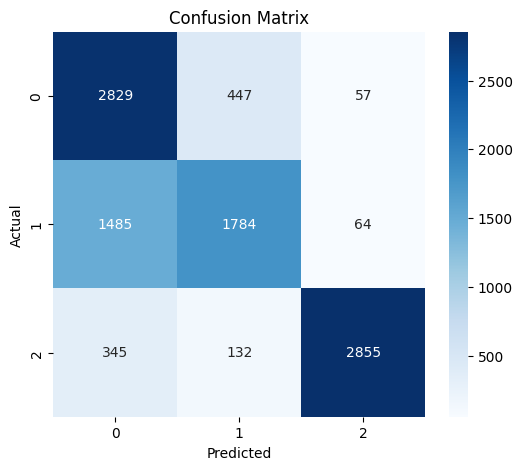

In [18]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "unsloth/Llama-3.2-1B-bnb-4bit"
best_model_path = "Models/exp(Llama-3.2-1B-bnb-4bit)_LoRA_best_model_1.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

params = {'batch_size': 128, 'shuffle': True, 'num_workers': 0}
test_loader = inicialize_loader_test(df_test_IR, tokenizer, device, params)

test_metrics, cm = evaluate_test(model, test_loader, best_model_path, show_cm=True)

#### **LoRA-Llama3.2-3B**
> Execute: 5

In [ ]:
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F

#device = "cuda" if torch.cuda.is_available() else "cpu"

# Parámetros
decoder_name = "unsloth/Llama-3.2-3B-bnb-4bit"
emb_size = 3072
r = 8
lora_alpha = 32
lora_dropout = 0.2
weight_decay = 1e-4
betas = (0.9, 0.95)
lr = 3e-4
num_classes = 3

#from google.colab import drive
#drive.mount('/content/drive')
#model_path = "/content/drive/MyDrive/TFM/exp(Llama-3.2-3B-bnb-4bit)_LoRA_best_model_1 (1).pth"
model_path = "Models/exp(Llama-3.2-3B-bnb-4bit)_LoRA_best_model_5.pth"

# Modelo y optimizador con builder
model, optimizer = model_builder(
    decoder_name=decoder_name,
    emb_size=emb_size,
    lr=lr,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    weight_decay=weight_decay,
    betas=betas,
)

model = model.to(device)

def filter_state_dict(state_dict, model):
    model_keys = set(model.state_dict().keys())
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_keys}
    return filtered_dict

checkpoint = torch.load(model_path, map_location=device)

lora_state_dict = filter_state_dict(checkpoint["lora"], model.decoder)
model.decoder.load_state_dict(lora_state_dict, strict=False)
model.classifier.load_state_dict(checkpoint["classifier"])
model.linear_projection.load_state_dict(checkpoint["projection"])

model.eval()

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Test Accuracy: 0.7638, Precision: 0.7886, Recall: 0.7638, F1-score: 0.7543


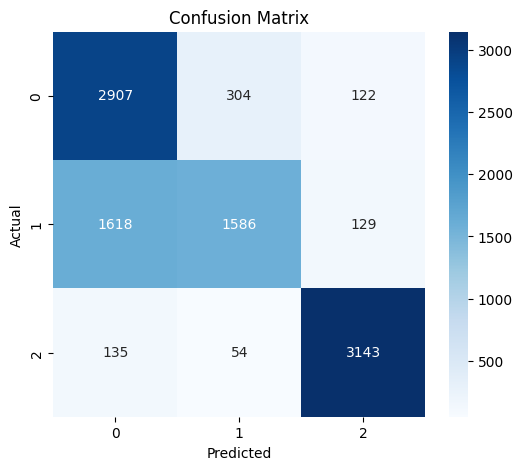

In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "unsloth/Llama-3.2-3B-bnb-4bit"
#best_model_path = "/content/drive/MyDrive/TFM/exp(Llama-3.2-3B-bnb-4bit)_LoRA_best_model_1 (1).pth"
best_model_path = "Models/exp(Llama-3.2-3B-bnb-4bit)_LoRA_best_model_5.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

params = {'batch_size': 128, 'shuffle': True, 'num_workers': 0}
test_loader = inicialize_loader_test(df_test_IR, tokenizer, device, params)

test_metrics, cm = evaluate_test(model, test_loader, best_model_path, show_cm=True)

#### **LoRA-Llama3.1-8B**
> Execute: 138

In [ ]:
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F


# Parámetros
decoder_name = "unsloth/Llama-3.1-8B-unsloth-bnb-4bit"
emb_size = 4096
r = 10
lora_alpha = 64
lora_dropout = 0.05
weight_decay = 1e-7
betas = (0.9, 0.95)
lr = 6e-4
num_classes = 3

model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_138.pth"

# Modelo y optimizador con builder
model, optimizer = model_builder(
    decoder_name=decoder_name,
    emb_size=emb_size,
    lr=lr,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    weight_decay=weight_decay,
    betas=betas,
)

model = model.to(device)

def filter_state_dict(state_dict, model):
    model_keys = set(model.state_dict().keys())
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_keys}
    return filtered_dict

checkpoint = torch.load(model_path, map_location=device)

lora_state_dict = filter_state_dict(checkpoint["lora"], model.decoder)
model.decoder.load_state_dict(lora_state_dict, strict=False)
model.classifier.load_state_dict(checkpoint["classifier"])
model.linear_projection.load_state_dict(checkpoint["projection"])

model.eval()

Test Accuracy: 0.7060, Precision: 0.7466, Recall: 0.7060, F1-score: 0.7132


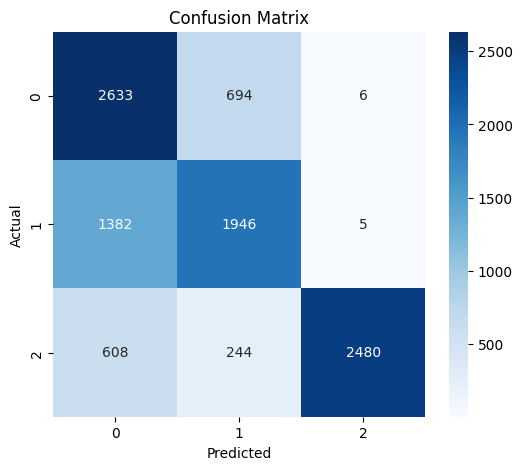

In [28]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "unsloth/Llama-3.1-8B-unsloth-bnb-4bit"
#best_model_path = "/content/drive/MyDrive/TFM/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_1 (1).pth"
best_model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_138.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

params = {'batch_size': 128, 'shuffle': True, 'num_workers': 0}
test_loader = inicialize_loader_test(df_test_IR, tokenizer, device, params)

test_metrics, cm = evaluate_test(model, test_loader, best_model_path, show_cm=True)

> Execute: 150

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.691 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.6.2 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Test Accuracy: 0.7854, Precision: 0.8084, Recall: 0.7854, F1-score: 0.7791


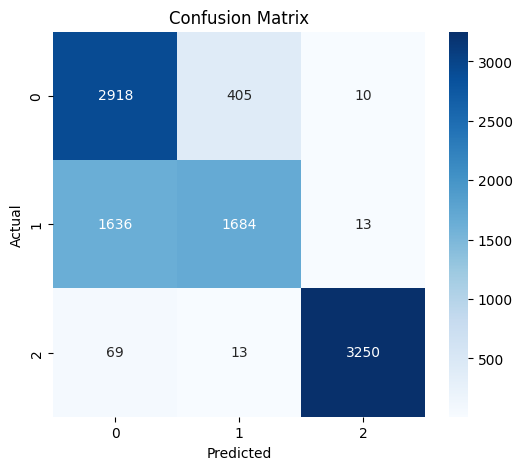

In [11]:
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F


# Parámetros
decoder_name = "unsloth/Llama-3.1-8B-unsloth-bnb-4bit"
emb_size = 4096
r = 10
lora_alpha = 64
lora_dropout = 0.05
weight_decay = 1e-5
betas = (0.9, 0.95)
lr = 6e-4
num_classes = 3

model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_150_val_loss.pth"

# Modelo y optimizador con builder
model, optimizer = model_builder(
    decoder_name=decoder_name,
    emb_size=emb_size,
    lr=lr,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    weight_decay=weight_decay,
    betas=betas,
)

model = model.to(device)

def filter_state_dict(state_dict, model):
    model_keys = set(model.state_dict().keys())
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_keys}
    return filtered_dict

checkpoint = torch.load(model_path, map_location=device)

lora_state_dict = filter_state_dict(checkpoint["lora"], model.decoder)
model.decoder.load_state_dict(lora_state_dict, strict=False)
model.classifier.load_state_dict(checkpoint["classifier"])
model.linear_projection.load_state_dict(checkpoint["projection"])

model.eval()

from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "unsloth/Llama-3.1-8B-unsloth-bnb-4bit"
#best_model_path = "/content/drive/MyDrive/TFM/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_1 (1).pth"
best_model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_150_val_loss.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

params = {'batch_size': 128, 'shuffle': True, 'num_workers': 0}
test_loader = inicialize_loader_test(df_test_IR, tokenizer, device, params)

test_metrics, cm = evaluate_test(model, test_loader, best_model_path, show_cm=True)

### ‼️ Definición de FEVER-Score
---

El esquema a seguir es el siguiente:
> 1. Se parte de los dos test set [0R, IR]. "OR" hace referencia al test set cuyas evidencias proceden de FEVER. "IR" es el test set con las evidencias recueperadas del módulo IR.
> 2. Se calculan las predicciones del IR test set.

**Para los Claims [SUPPORTES, REFUSES]...**

> 4. Se comparan las evidencias recuperadas en el IR test set con las del OR test set.
>    - Caso de Claim con dos evidencias/OR: una de las dos evidencias OR debe coincidir con alguna de las evidencias recuperadas en IR
>    - Caso de Claim con una evidencia/OR: una de las dos evidencias recuperadas en IR debe coincidir con la evidencia de OR.
> 5. Según coincidencia/no coincidencia:
>    - Si hay coincidencia y true_label = predicted_label; +1 en la métrica
>    - Si hay coincidencia y true_label != predicted_label; +-0 en la métrica
>    - Si no hay coincidencia; +-0 en la métrica (independientemente de la predicción)

**Para los Claims [NOT ENOUGH INFO]...**
> 5. Si true_label = predicted_label; +1 en la métrica. If not: +-0.

A continuación, se implementan dos métricas. 

- FEVER Score + es más restrictiva.
- FEVER Score es la originaria del paper, a nivel documental.

#### 1. Métrica FEVER Score+ (Documental). Esta métrica es más estricta que la utilizada en los modelos de FEVER
---

> Requisito en IR: en aquellos casos en los que haya dos evidencias en FEVER, ambas deben cumplir que similitud > 0.9 con las recuperadas.
>
> Esta métrica trabaja a nivel documental. En el estado del arte, y en la tarea oficial, FEVER score se aplica sobre embeddings a nivel de frase.

*Se prueba sobre el modelo Llama3.1-8B*

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def embedding_ir_comparative(row_ir, row_or, k=2, sim_threshold=1):
    retrieved_embs = row_ir['evidence'][:k]
    gold_embs = row_or['evidence']

    try:
        if len(retrieved_embs) == 0 or len(gold_embs) == 0:
            return None
        retrieved_embs = np.vstack(retrieved_embs).astype(np.float32)
        gold_embs = np.vstack(gold_embs).astype(np.float32)
    except Exception:
        return None

    sims = cosine_similarity(gold_embs, retrieved_embs)
    all_gold_covered = np.all(np.max(sims, axis=1) >= sim_threshold)

    return int(all_gold_covered)


def predict_labels(model, test_loader):
    print("### Calculando predicciones...")
    model.eval()
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            inputs_embeds = data['inputs_embeds'].to(device)
            attention_mask = data['attention_mask'].to(device).to(torch.float32)

            logits = model(inputs_embeds, attention_mask)
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())

    return predictions

In [27]:
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer


df_test_IR = pd.read_json("testSet_default_faiss.jsonl", lines=True)
df_test_OR = pd.read_json("../data/e_test_distractors_LoRA_split.jsonl", lines=True)

df_test_IR.rename(columns={"evidences": "evidence"}, inplace=True)
########################################################################################
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F


# Parámetros
decoder_name = "unsloth/Llama-3.1-8B-unsloth-bnb-4bit"
emb_size = 4096
r = 10
lora_alpha = 64
lora_dropout = 0.05
weight_decay = 1e-5
betas = (0.9, 0.95)
lr = 6e-4
num_classes = 3

model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_150.pth"

# Modelo y optimizador con builder
model, optimizer = model_builder(
    decoder_name=decoder_name,
    emb_size=emb_size,
    lr=lr,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    weight_decay=weight_decay,
    betas=betas,
)

model = model.to(device)

def filter_state_dict(state_dict, model):
    model_keys = set(model.state_dict().keys())
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_keys}
    return filtered_dict

checkpoint = torch.load(model_path, map_location=device)

lora_state_dict = filter_state_dict(checkpoint["lora"], model.decoder)
model.decoder.load_state_dict(lora_state_dict, strict=False)
model.classifier.load_state_dict(checkpoint["classifier"])
model.linear_projection.load_state_dict(checkpoint["projection"])

model.eval()

model_name = "unsloth/Llama-3.1-8B-bnb-4bit"
best_model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_150.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

params = {'batch_size': 128, 'shuffle': False, 'num_workers': 0}

### Datos
print("### Cargando datos")
test_loader = inicialize_loader_test(df_test_IR, tokenizer, device, params)

########################################################################################
preds = predict_labels(model, test_loader)
df_test_IR["predicted_label_code"] = preds

# Codificación
label_to_code = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT ENOUGH INFO": 2
}
code_to_label = {v: k for k, v in label_to_code.items()}

df_test_OR = df_test_OR.rename(columns={"label": "true_label"})
df_test_OR["true_label_code"] = df_test_OR["true_label"].map(label_to_code)

df_test_IR = df_test_IR.rename(columns={"label": "true_label"})
df_test_IR["true_label_code"] = df_test_IR["true_label"].map(label_to_code)

df_test_IR["predicted_label"] = df_test_IR["predicted_label_code"].map(code_to_label)
########################################################################################

total_filas = len(df_test_IR)

count_ones = 0
count_zeros = 0
score = 0
total_evaluated = 0

for i in range(total_filas):
    row_ir = df_test_IR.iloc[i]
    row_or = df_test_OR.iloc[i]

    # evidence es vacía (NEI)
    if len(row_or['evidence']) == 0:
        # comparacion de etiquetas
        total_evaluated += 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
        continue

    # Si evidence NO es vacía = aplicamos la función de similitud
    match = embedding_ir_comparative(row_ir, row_or, k=2, sim_threshold=1)

    if match is None:
        continue

    total_evaluated += 1

    if match == 1:
        count_ones += 1
        # Comparamos etiquetas solo si match = 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
    else:
        count_zeros += 1

metric = score / total_evaluated if total_evaluated > 0 else 0

print(f"Total filas: {total_filas}")
print(f"Total filas evaluadas (incluyendo NEI): {total_evaluated}")
print(f"FEVER Score: {metric:.4f}")

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.352 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
### Cargando datos
### Calculando predicciones...
Total filas: 9998
Total filas evaluadas (incluyendo NEI): 9916
FEVER Score: 0.6503


#### 2. **Métrica FEVER Score (Documental) del Paper Original de FEVER**
---
> Paper: The Fact Extraction and VERification (FEVER) Shared Task - https://arxiv.org/pdf/1811.10971

> Code: https://github.com/sheffieldnlp/fever-scorer

> Esta métrica trabaja a nivel documental. En el estado del arte, y en la tarea oficial, FEVER score se aplica sobre embeddings a nivel de frase.

*Se prueba sobre el modelo Llama3.1-8B*

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def embedding_ir_comparative(row_ir, row_or, k=2, sim_threshold=1):
    retrieved_embs = row_ir['evidence'][:k]
    gold_embs = row_or['evidence']

    try:
        if len(retrieved_embs) == 0 or len(gold_embs) == 0:
            # Caso NEI o evidencia vacía
            return None
        retrieved_embs = np.vstack(retrieved_embs).astype(np.float32)
        gold_embs = np.vstack(gold_embs).astype(np.float32)
    except Exception:
        return None

    sims = cosine_similarity(retrieved_embs, gold_embs)
    max_sim = np.max(sims)

    return int(max_sim >= sim_threshold)

def predict_labels(model, test_loader):
    print("### Calculando predicciones...")
    model.eval()
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            inputs_embeds = data['inputs_embeds'].to(device)
            attention_mask = data['attention_mask'].to(device).to(torch.float32)

            logits = model(inputs_embeds, attention_mask)
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())

    return predictions

In [23]:
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer


df_test_IR = pd.read_json("testSet_default_faiss.jsonl", lines=True)
df_test_OR = pd.read_json("../data/e_test_distractors_LoRA_split.jsonl", lines=True)

df_test_IR.rename(columns={"evidences": "evidence"}, inplace=True)
########################################################################################
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F


# Parámetros
decoder_name = "unsloth/Llama-3.1-8B-unsloth-bnb-4bit"
emb_size = 4096
r = 10
lora_alpha = 64
lora_dropout = 0.05
weight_decay = 1e-5
betas = (0.9, 0.95)
lr = 6e-4
num_classes = 3

model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_150.pth"

# Modelo y optimizador con builder
model, optimizer = model_builder(
    decoder_name=decoder_name,
    emb_size=emb_size,
    lr=lr,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    weight_decay=weight_decay,
    betas=betas,
)

model = model.to(device)

def filter_state_dict(state_dict, model):
    model_keys = set(model.state_dict().keys())
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_keys}
    return filtered_dict

checkpoint = torch.load(model_path, map_location=device)

lora_state_dict = filter_state_dict(checkpoint["lora"], model.decoder)
model.decoder.load_state_dict(lora_state_dict, strict=False)
model.classifier.load_state_dict(checkpoint["classifier"])
model.linear_projection.load_state_dict(checkpoint["projection"])

model.eval()

model_name = "unsloth/Llama-3.1-8B-bnb-4bit"
best_model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_150.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

params = {'batch_size': 128, 'shuffle': False, 'num_workers': 0}

### Datos
print("### Cargando datos")
test_loader = inicialize_loader_test(df_test_IR, tokenizer, device, params)

########################################################################################
preds = predict_labels(model, test_loader)
df_test_IR["predicted_label_code"] = preds

# Codificación
label_to_code = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT ENOUGH INFO": 2
}
code_to_label = {v: k for k, v in label_to_code.items()}

df_test_OR = df_test_OR.rename(columns={"label": "true_label"})
df_test_OR["true_label_code"] = df_test_OR["true_label"].map(label_to_code)

df_test_IR = df_test_IR.rename(columns={"label": "true_label"})
df_test_IR["true_label_code"] = df_test_IR["true_label"].map(label_to_code)

df_test_IR["predicted_label"] = df_test_IR["predicted_label_code"].map(code_to_label)
########################################################################################

total_filas = len(df_test_IR)

count_ones = 0
count_zeros = 0
score = 0
total_evaluated = 0

for i in range(total_filas):
    row_ir = df_test_IR.iloc[i]
    row_or = df_test_OR.iloc[i]

    # evidence es vacía (NEI)
    if len(row_or['evidence']) == 0:
        # comparacion de etiquetas
        total_evaluated += 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
        continue

    # Si evidence NO es vacía = aplicamos la función de similitud
    match = embedding_ir_comparative(row_ir, row_or, k=2, sim_threshold=1)

    if match is None:
        continue

    total_evaluated += 1

    if match == 1:
        count_ones += 1
        # Comparamos etiquetas solo si match = 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
    else:
        count_zeros += 1

metric = score / total_evaluated if total_evaluated > 0 else 0

print(f"Total filas: {total_filas}")
print(f"Total filas evaluadas (incluyendo NEI): {total_evaluated}")
print(f"FEVER Score: {metric:.4f}")

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.352 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
### Cargando datos
### Calculando predicciones...
Total filas: 9998
Total filas evaluadas (incluyendo NEI): 9916
FEVER Score: 0.6734


### **Evaluación FEVER Score de las 3 arquitecturas**
---

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def embedding_ir_comparative(row_ir, row_or, k=2, sim_threshold=1):
    retrieved_embs = row_ir['evidence'][:k]
    gold_embs = row_or['evidence']

    try:
        if len(retrieved_embs) == 0 or len(gold_embs) == 0:
            # Caso NEI o evidencia vacía
            return None
        retrieved_embs = np.vstack(retrieved_embs).astype(np.float32)
        gold_embs = np.vstack(gold_embs).astype(np.float32)
    except Exception:
        return None

    sims = cosine_similarity(retrieved_embs, gold_embs)
    max_sim = np.max(sims)

    return int(max_sim >= sim_threshold)

def predict_labels(model, test_loader):
    print("### Calculando predicciones...")
    model.eval()
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            inputs_embeds = data['inputs_embeds'].to(device)
            attention_mask = data['attention_mask'].to(device).to(torch.float32)

            logits = model(inputs_embeds, attention_mask)
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())

    return predictions

#### **Llama3.2-1B**

In [37]:
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer


df_test_IR = pd.read_json("testSet_default_faiss.jsonl", lines=True)
df_test_OR = pd.read_json("../data/e_test_distractors_LoRA_split.jsonl", lines=True)

df_test_IR.rename(columns={"evidences": "evidence"}, inplace=True)
########################################################################################
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F


# Parámetros
decoder_name = "unsloth/Llama-3.2-1B-bnb-4bit"
emb_size = 2048
r = 4
lora_alpha = 16
lora_dropout = 0.1
weight_decay = 0.07
betas = (0.9, 0.95)
lr = 3e-4
num_classes = 3

model_path = "Models/exp(Llama-3.2-1B-bnb-4bit)_LoRA_best_model_1.pth"

# Modelo y optimizador con builder
model, optimizer = model_builder(
    decoder_name=decoder_name,
    emb_size=emb_size,
    lr=lr,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    weight_decay=weight_decay,
    betas=betas,
)

model = model.to(device)

def filter_state_dict(state_dict, model):
    model_keys = set(model.state_dict().keys())
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_keys}
    return filtered_dict

checkpoint = torch.load(model_path, map_location=device)

lora_state_dict = filter_state_dict(checkpoint["lora"], model.decoder)
model.decoder.load_state_dict(lora_state_dict, strict=False)
model.classifier.load_state_dict(checkpoint["classifier"])
model.linear_projection.load_state_dict(checkpoint["projection"])

model.eval()

model_name = "unsloth/Llama-3.2-1B-bnb-4bit"
model_path = "Models/exp(Llama-3.2-1B-bnb-4bit)_LoRA_best_model_1.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

params = {'batch_size': 128, 'shuffle': False, 'num_workers': 0}

### Datos
print("### Cargando datos")
test_loader = inicialize_loader_test(df_test_IR, tokenizer, device, params)

########################################################################################
preds = predict_labels(model, test_loader)
df_test_IR["predicted_label_code"] = preds

# Codificación
label_to_code = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT ENOUGH INFO": 2
}
code_to_label = {v: k for k, v in label_to_code.items()}

df_test_OR = df_test_OR.rename(columns={"label": "true_label"})
df_test_OR["true_label_code"] = df_test_OR["true_label"].map(label_to_code)

df_test_IR = df_test_IR.rename(columns={"label": "true_label"})
df_test_IR["true_label_code"] = df_test_IR["true_label"].map(label_to_code)

df_test_IR["predicted_label"] = df_test_IR["predicted_label_code"].map(code_to_label)
########################################################################################

total_filas = len(df_test_IR)

count_ones = 0
count_zeros = 0
score = 0
total_evaluated = 0

for i in range(total_filas):
    row_ir = df_test_IR.iloc[i]
    row_or = df_test_OR.iloc[i]

    # evidence es vacía (NEI)
    if len(row_or['evidence']) == 0:
        # comparacion de etiquetas
        total_evaluated += 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
        continue

    # Si evidence NO es vacía = aplicamos la función de similitud
    match = embedding_ir_comparative(row_ir, row_or, k=2, sim_threshold=1)

    if match is None:
        continue

    total_evaluated += 1

    if match == 1:
        count_ones += 1
        # Comparamos etiquetas solo si match = 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
    else:
        count_zeros += 1

metric = score / total_evaluated if total_evaluated > 0 else 0

print(f"Total filas: {total_filas}")
print(f"Total filas evaluadas (incluyendo NEI): {total_evaluated}")
print(f"FEVER Score: {metric:.4f}")

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.352 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
### Cargando datos
### Calculando predicciones...
Total filas: 9998
Total filas evaluadas (incluyendo NEI): 9916
FEVER Score: 0.6350


#### **Llama3.2-3B**

In [38]:
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer


df_test_IR = pd.read_json("testSet_default_faiss.jsonl", lines=True)
df_test_OR = pd.read_json("../data/e_test_distractors_LoRA_split.jsonl", lines=True)

df_test_IR.rename(columns={"evidences": "evidence"}, inplace=True)
########################################################################################
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F


# Parámetros
decoder_name = "unsloth/Llama-3.2-3B-bnb-4bit"
emb_size = 3072
r = 8
lora_alpha = 32
lora_dropout = 0.2
weight_decay = 1e-4
betas = (0.9, 0.95)
lr = 3e-4
num_classes = 3


model_path = "Models/exp(Llama-3.2-3B-bnb-4bit)_LoRA_best_model_5.pth"

# Modelo y optimizador con builder
model, optimizer = model_builder(
    decoder_name=decoder_name,
    emb_size=emb_size,
    lr=lr,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    weight_decay=weight_decay,
    betas=betas,
)

model = model.to(device)

def filter_state_dict(state_dict, model):
    model_keys = set(model.state_dict().keys())
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_keys}
    return filtered_dict

checkpoint = torch.load(model_path, map_location=device)

lora_state_dict = filter_state_dict(checkpoint["lora"], model.decoder)
model.decoder.load_state_dict(lora_state_dict, strict=False)
model.classifier.load_state_dict(checkpoint["classifier"])
model.linear_projection.load_state_dict(checkpoint["projection"])

model.eval()

model_name = "unsloth/Llama-3.2-3B-bnb-4bit"
model_path = "Models/exp(Llama-3.2-3B-bnb-4bit)_LoRA_best_model_5.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

params = {'batch_size': 128, 'shuffle': False, 'num_workers': 0}

### Datos
print("### Cargando datos")
test_loader = inicialize_loader_test(df_test_IR, tokenizer, device, params)

########################################################################################
preds = predict_labels(model, test_loader)
df_test_IR["predicted_label_code"] = preds

# Codificación
label_to_code = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT ENOUGH INFO": 2
}
code_to_label = {v: k for k, v in label_to_code.items()}

df_test_OR = df_test_OR.rename(columns={"label": "true_label"})
df_test_OR["true_label_code"] = df_test_OR["true_label"].map(label_to_code)

df_test_IR = df_test_IR.rename(columns={"label": "true_label"})
df_test_IR["true_label_code"] = df_test_IR["true_label"].map(label_to_code)

df_test_IR["predicted_label"] = df_test_IR["predicted_label_code"].map(code_to_label)
########################################################################################

total_filas = len(df_test_IR)

count_ones = 0
count_zeros = 0
score = 0
total_evaluated = 0

for i in range(total_filas):
    row_ir = df_test_IR.iloc[i]
    row_or = df_test_OR.iloc[i]

    # evidence es vacía (NEI)
    if len(row_or['evidence']) == 0:
        # comparacion de etiquetas
        total_evaluated += 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
        continue

    # Si evidence NO es vacía = aplicamos la función de similitud
    match = embedding_ir_comparative(row_ir, row_or, k=2, sim_threshold=1)

    if match is None:
        continue

    total_evaluated += 1

    if match == 1:
        count_ones += 1
        # Comparamos etiquetas solo si match = 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
    else:
        count_zeros += 1

metric = score / total_evaluated if total_evaluated > 0 else 0

print(f"Total filas: {total_filas}")
print(f"Total filas evaluadas (incluyendo NEI): {total_evaluated}")
print(f"FEVER Score: {metric:.4f}")

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.352 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
### Cargando datos
### Calculando predicciones...
Total filas: 9998
Total filas evaluadas (incluyendo NEI): 9916
FEVER Score: 0.6579


#### **Llama3.1-8B**

In [35]:
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer


df_test_IR = pd.read_json("testSet_default_faiss.jsonl", lines=True)
df_test_OR = pd.read_json("../data/e_test_distractors_LoRA_split.jsonl", lines=True)

df_test_IR.rename(columns={"evidences": "evidence"}, inplace=True)
########################################################################################
import torch
from unsloth import FastLanguageModel
import torch.nn.functional as F


# Parámetros
decoder_name = "unsloth/Llama-3.1-8B-unsloth-bnb-4bit"
emb_size = 4096
r = 10
lora_alpha = 64
lora_dropout = 0.05
weight_decay = 1e-5
betas = (0.9, 0.95)
lr = 6e-4
num_classes = 3

model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_150.pth"

# Modelo y optimizador con builder
model, optimizer = model_builder(
    decoder_name=decoder_name,
    emb_size=emb_size,
    lr=lr,
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    weight_decay=weight_decay,
    betas=betas,
)

model = model.to(device)

def filter_state_dict(state_dict, model):
    model_keys = set(model.state_dict().keys())
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_keys}
    return filtered_dict

checkpoint = torch.load(model_path, map_location=device)

lora_state_dict = filter_state_dict(checkpoint["lora"], model.decoder)
model.decoder.load_state_dict(lora_state_dict, strict=False)
model.classifier.load_state_dict(checkpoint["classifier"])
model.linear_projection.load_state_dict(checkpoint["projection"])

model.eval()

model_name = "unsloth/Llama-3.1-8B-bnb-4bit"
best_model_path = "Models/exp(Llama-3.1-8B-bnb-4bit)_LoRA_best_model_150.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

params = {'batch_size': 128, 'shuffle': False, 'num_workers': 0}

### Datos
print("### Cargando datos")
test_loader = inicialize_loader_test(df_test_IR, tokenizer, device, params)

########################################################################################
preds = predict_labels(model, test_loader)
df_test_IR["predicted_label_code"] = preds

# Codificación
label_to_code = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT ENOUGH INFO": 2
}
code_to_label = {v: k for k, v in label_to_code.items()}

df_test_OR = df_test_OR.rename(columns={"label": "true_label"})
df_test_OR["true_label_code"] = df_test_OR["true_label"].map(label_to_code)

df_test_IR = df_test_IR.rename(columns={"label": "true_label"})
df_test_IR["true_label_code"] = df_test_IR["true_label"].map(label_to_code)

df_test_IR["predicted_label"] = df_test_IR["predicted_label_code"].map(code_to_label)
########################################################################################

total_filas = len(df_test_IR)

count_ones = 0
count_zeros = 0
score = 0
total_evaluated = 0

for i in range(total_filas):
    row_ir = df_test_IR.iloc[i]
    row_or = df_test_OR.iloc[i]

    # evidence es vacía (NEI)
    if len(row_or['evidence']) == 0:
        # comparacion de etiquetas
        total_evaluated += 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
        continue

    # Si evidence NO es vacía = aplicamos la función de similitud
    match = embedding_ir_comparative(row_ir, row_or, k=2, sim_threshold=1)

    if match is None:
        continue

    total_evaluated += 1

    if match == 1:
        count_ones += 1
        # Comparamos etiquetas solo si match = 1
        if row_ir['predicted_label_code'] == row_or['true_label_code']:
            score += 1
    else:
        count_zeros += 1

metric = score / total_evaluated if total_evaluated > 0 else 0

print(f"Total filas: {total_filas}")
print(f"Total filas evaluadas (incluyendo NEI): {total_evaluated}")
print(f"FEVER Score: {metric:.4f}")

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.352 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
### Cargando datos
### Calculando predicciones...
Total filas: 9998
Total filas evaluadas (incluyendo NEI): 9916
FEVER Score: 0.6734
